# Подготовка данных

Считываем все файлы с диалогами из датасета

In [11]:
import pandas as pd
import glob
import re

In [12]:
# Чтение всех CSV-файлов с диалогами
all_files = glob.glob("/content/drive/MyDrive/MFTI/NLP/HouseMD/*.csv")
df_list = [pd.read_csv(f, encoding='utf-8', encoding_errors='replace') for f in all_files]
df = pd.concat(df_list, ignore_index=True)

print(df.columns)
print(df.head(5))
print(f"Total lines: {len(df)}")


Index(['name', 'line', 'context', 'house_reply'], dtype='object')
      name                                               line context  \
0    House                              Pericardial effusion.     NaN   
1     Taub   Which wasn't there last night when we did the...     NaN   
2  Foreman   She's getting worse, and there's no sign of a...     NaN   
3    Chase                                 Or maybe a cancer.     NaN   
4  Foreman   We could use your opinion, House, or at least...     NaN   

  house_reply  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
Total lines: 97121


Очистка строк

In [13]:
def clean_line(line: str) -> str:
    # Превращаем в строку
    text = str(line)
    # Удаляем содержимое в квадратных скобках
    text = re.sub(r'\[.*?\]', '', text)
    # Удаляем содержимое в круглых скобках
    text = re.sub(r'\(.*?\)', '', text)
    # Убираем символ ќ (если встречается)
    text = text.replace('ќ', '')
    # Заменяем двойные кавычки
    text = text.replace('""', '"')
    # Удаляем лишние пробелы в начале и конце
    text = text.strip()
    return text

In [14]:
# Применяем очистку к столбцу line
df['line'] = df['line'].apply(clean_line)

# Удаляем пустые реплики
df = df[df['line'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

print(df.head(10))
print(f"Total lines after cleaning: {len(df)}")

      name                                               line context  \
0    House                              Pericardial effusion.     NaN   
1     Taub  Which wasn't there last night when we did the ...     NaN   
2  Foreman  She's getting worse, and there's no sign of a ...     NaN   
3    Chase                                 Or maybe a cancer.     NaN   
4  Foreman  We could use your opinion, House, or at least ...     NaN   
5    House  Jack Cannon is not dead. It's worse. Ten books...     NaN   
6     Taub              People who want to sell you the 11th.     NaN   
7    House  She was gonna kill herself. This is the final ...     NaN   
8    Chase  Is there anything in it that pertains to our c...     NaN   
9    House       Yeah. I know why she wanted to kill herself.     NaN   

  house_reply  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  
Total lines after cl

Идея состоит в том, чтобы для каждой реплики Хауса взять предыдущую реплику (независимо от того, кто её произнёс) и переименовать её как User

In [15]:
data = []
for i in range(1, len(df)):
    # Приводим имя к строке, чтобы избежать ошибки
    name_val = str(df.loc[i, 'name'])
    if name_val.strip().lower() == 'house':
        context = "User: " + str(df.loc[i-1, 'line'])
        house_reply = "House: " + str(df.loc[i, 'line'])
        data.append((context, house_reply))

df_dialogs = pd.DataFrame(data, columns=['context', 'house_reply'])
print(df_dialogs.head(10))
print(f"Total lines of dialogs: {len(df_dialogs)}")

                                             context  \
0  User: We could use your opinion, House, or at ...   
1        User: People who want to sell you the 11th.   
2  User: Is there anything in it that pertains to...   
3  User: Yeah. I know why she wanted to kill hers...   
4  User: How do we know this mentor character's r...   
5  User: If we add those to the symptoms we've se...   
6  User: Given good!  !ish behavior and 8 of 12 m...   
7                                         User: Yes?   
8                  User: Are you trying to annoy us?   
9              User: We need you to show us remorse.   

                                         house_reply  
0  House: Jack Cannon is not dead. It's worse. Te...  
1  House: She was gonna kill herself. This is the...  
2  House: Yeah. I know why she wanted to kill her...  
3  House: His mentor, Helen Rutherford, has contr...  
4  House: Helen dies halfway through the book. Sh...  
5                             House: Can't be lupus. 

Сохранение результата в csv для дальнейшей работы

In [9]:
output_path = "/content/drive/MyDrive/MFTI/NLP/HouseMD/housemd_cleaned.csv"
df_dialogs.to_csv(output_path, index=False)

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

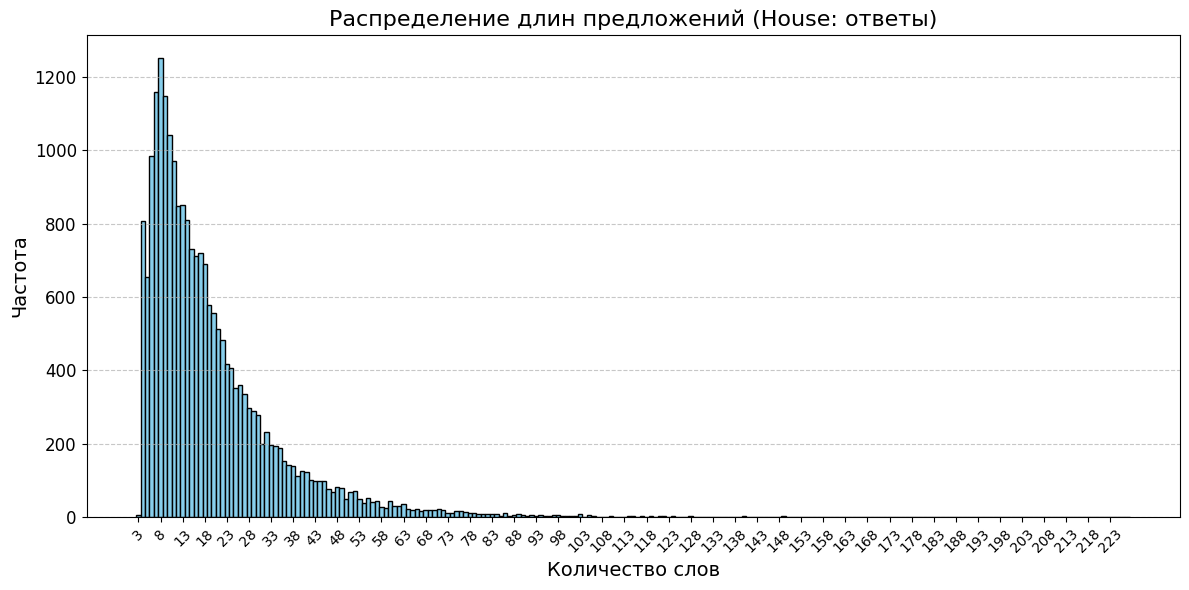

In [22]:
# Извлекаем реплики House
house_replies = df_dialogs['house_reply'].dropna().tolist()

# Рассчитываем длину каждого предложения (по количеству слов)
sentence_lengths = [len(nltk.word_tokenize(reply)) for reply in house_replies]

plt.figure(figsize=(12, 6))
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 2),
         edgecolor='black', align='left', color='skyblue')
plt.title("Распределение длин предложений (House: ответы)", fontsize=16)
plt.xlabel("Количество слов", fontsize=14)
plt.ylabel("Частота", fontsize=14)

# Устанавливаем шаг меток на оси X
plt.xticks(range(min(sentence_lengths), max(sentence_lengths) + 1, 5), fontsize=10, rotation=45)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

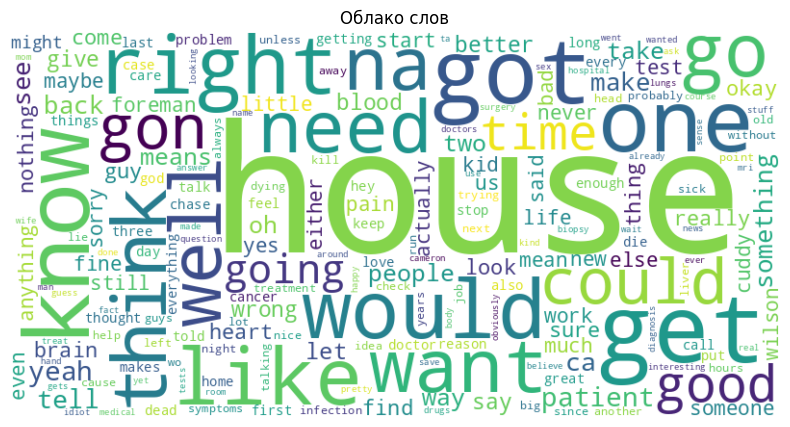

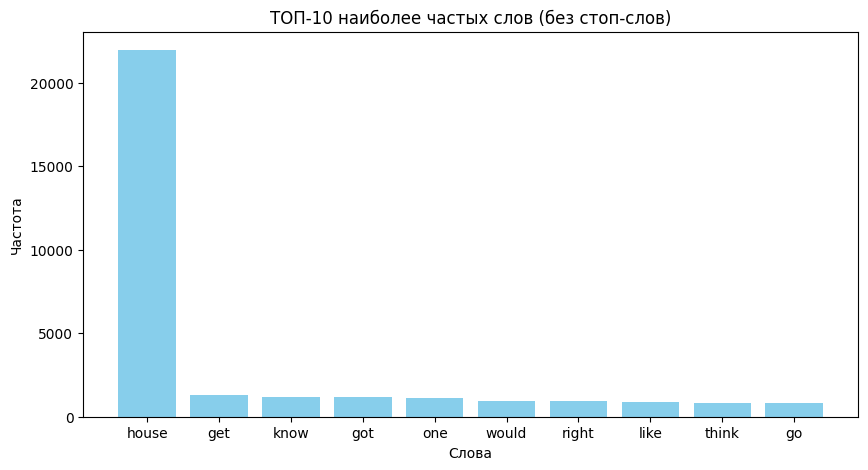

In [28]:
from nltk.corpus import stopwords
# Получаем список английских стоп-слов
stop_words = set(stopwords.words('english'))

# Объединяем все реплики House в один текст
text = " ".join(df_dialogs['house_reply'].dropna().tolist())

# Разбиваем текст на слова, приводим к нижнему регистру
words = nltk.word_tokenize(text.lower())

# Убираем пунктуацию и стоп-слова
words = [word for word in words if word.isalnum() and word not in stop_words]

# Подсчёт частоты слов
word_freq = Counter(words)

# Построение облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Облако слов")
plt.show()

# Альтернативно: гистограмма ТОП-10 наиболее частых слов
most_common = word_freq.most_common(10)
words_top, counts_top = zip(*most_common)

plt.figure(figsize=(10, 5))
plt.bar(words_top, counts_top, color='skyblue')
plt.title("ТОП-10 наиболее частых слов (без стоп-слов)")
plt.xlabel("Слова")
plt.ylabel("Частота")
plt.show()

#Обучение модели

Подготовка датасета для генеративного fine-tuning

In [1]:
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer
import pandas as pd

Создадим класс HouseDialogDataset, который будет загружать диалоговые пары из CSV и токенизировать их в нужный формат

In [2]:
class HouseDialogDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=256):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Получаем строку из DataFrame
        row = self.data.iloc[idx]
        # Формируем единый текстовый блок: контекст и ответ
        text = f"{row['context']}\n{row['house_reply']}"
        tokens = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = tokens.input_ids.squeeze()  # убираем размер батча
        attention_mask = tokens.attention_mask.squeeze()
        labels = input_ids.clone()
        # Маскируем паддинговые токены, чтобы не учитывались в loss
        labels[attention_mask == 0] = -100
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

Инициализируем токенайзер gpt2-medium

In [5]:
# Инициализация токенизатора
model_name = "gpt2-medium"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Провери длинну токенов в диалогах

Статистика по длинам токенов:
count    21809.000000
mean        38.142143
std         21.230841
min          8.000000
25%         23.000000
50%         33.000000
75%         47.000000
max        259.000000
Name: dialogue, dtype: float64


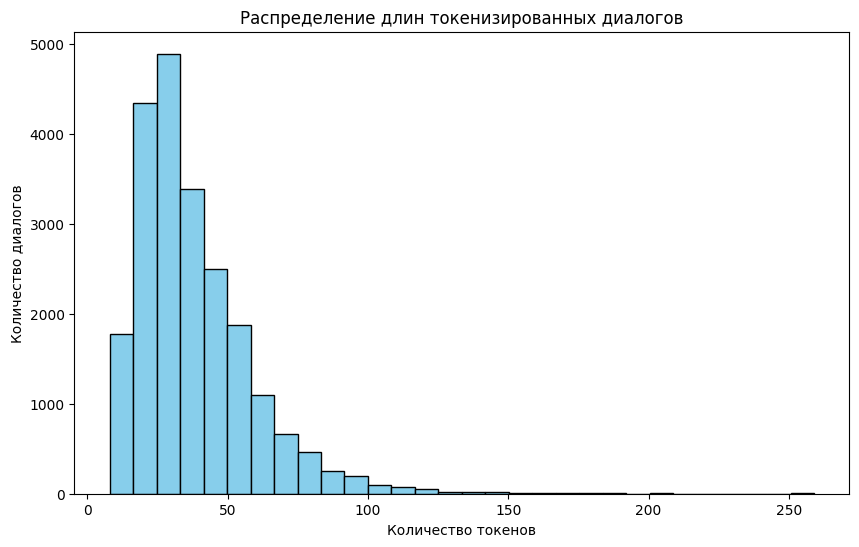

In [6]:
import matplotlib.pyplot as plt

# Загружаем датасет диалогов, который мы ранее сформировали
df_dialogs = pd.read_csv('/content/drive/MyDrive/MFTI/NLP/HouseMD/housemd_cleaned.csv')

# Объединяем контекст и ответ в один текстовый блок
df_dialogs['dialogue'] = df_dialogs['context'] + "\n" + df_dialogs['house_reply']

# Вычисляем длину каждого диалога в токенах, используя токенизатор
token_lengths = df_dialogs['dialogue'].apply(lambda x: len(tokenizer.encode(x)))

# Выводим статистику по длинам
print("Статистика по длинам токенов:")
print(token_lengths.describe())

# Строим гистограмму распределения длин токенизированных диалогов
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Количество токенов')
plt.ylabel('Количество диалогов')
plt.title('Распределение длин токенизированных диалогов')
plt.show()


Из графика видно, что возможну установить максимальную длинну диалогов в 128 токенов

In [7]:
# Создаем датасет
csv_path = "/content/drive/MyDrive/MFTI/NLP/HouseMD/housemd_cleaned.csv"
dataset = HouseDialogDataset(csv_path, tokenizer, max_length=128)

Пример токенизации

In [8]:
sample = dataset[0]
print(tokenizer.decode(sample["input_ids"], skip_special_tokens=True))

User: We could use your opinion, House, or at least your attention.
House: Jack Cannon is not dead. It's worse. Ten books leading up to a final confrontation. She ends it on a cliffhanger. Who does that?


Поверик количество доступных ядер

In [9]:
import os
print(os.cpu_count())

12


In [12]:
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments

# Загружаем предобученную модель GPT-2
model = GPT2LMHeadModel.from_pretrained(model_name)

# Определяем аргументы обучения
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/MFTI/NLP/house_gpt2",
    num_train_epochs=3,                       # число эпох
    per_device_train_batch_size=32,            # размер батча
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=100,
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=100,
    save_total_limit=2,
    report_to=[],
    fp16=True,
    dataloader_num_workers=12
)

# Используем training set для проверки
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset
)

# Запускаем обучение
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
100,3.199100,3.112190
200,3.068000,3.002346
300,3.023800,2.931422
400,3.006700,2.866679
500,2.972700,2.813822
600,2.957600,2.774696
700,2.851900,2.716245
800,2.719200,2.680770
900,2.720400,2.648644
1000,2.721100,2.623089


TrainOutput(global_step=2046, training_loss=2.7793024161927047, metrics={'train_runtime': 1281.9633, 'train_samples_per_second': 51.037, 'train_steps_per_second': 1.596, 'total_flos': 1.5190525085220864e+16, 'train_loss': 2.7793024161927047, 'epoch': 3.0})

Визуализируем резельтаты обучения

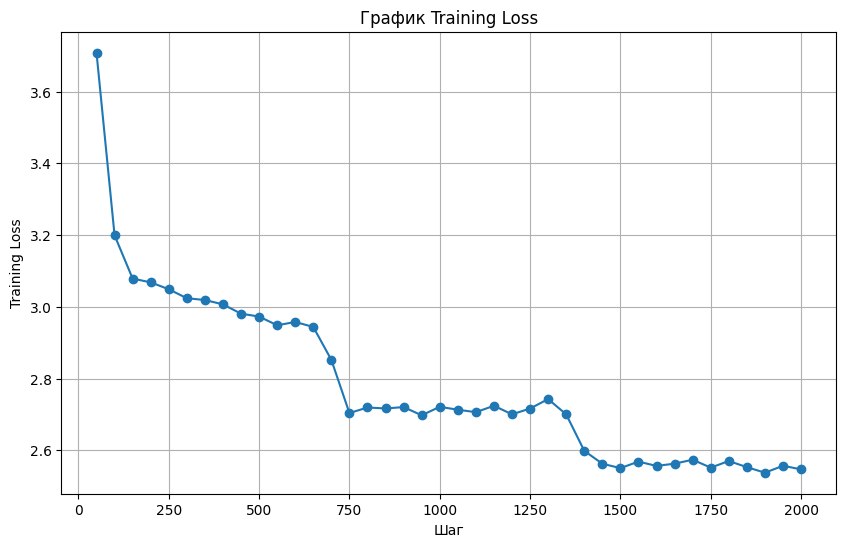

In [13]:
# Извлекаем историю логов
log_history = trainer.state.log_history

# Фильтруем записи, содержащие "loss"
loss_logs = [entry for entry in log_history if "loss" in entry]

# Получаем шаги и значения loss
steps = [entry["step"] for entry in loss_logs]
losses = [entry["loss"] for entry in loss_logs]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.xlabel("Шаг")
plt.ylabel("Training Loss")
plt.title("График Training Loss")
plt.grid(True)
plt.show()

Сохраним логи обучения в облаке

In [14]:
import json

with open("/content/drive/MyDrive/MFTI/NLP/house_logs.json", "w") as f:
    json.dump(trainer.state.log_history, f, indent=4)

#Инференс модели

Импортировать библиотек

In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [7]:
# Путь к сохранённой модели (контрольные точки)
model_path = "/content/drive/MyDrive/MFTI/NLP/house_gpt2/checkpoint-2046"

# Загрузите токенизатор и модель
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
model = GPT2LMHeadModel.from_pretrained(model_path)

tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

In [36]:
def generate_house_reply(user_input, max_length=50):
    # Формируем промпт: включаем вход пользователя и метку "House:"
    prompt = f"User: {user_input}\nHouse:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Генерация ответа с использованием настроек сэмплинга
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=100,
            top_p=0.9,
            temperature=0.9,
            no_repeat_ngram_size=3,
            # skip_special_tokens=True
        )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Извлекаем часть после "House:" для чистоты
    if "House:" in generated_text:
        house_text = generated_text.split("House:")[1]
    else:
        house_text = generated_text
    return house_text.strip()

In [42]:
# Пример генерации ответа
test_queries = [
    "Who lies?",
    "Are all people honest?",
    "What is your diagnosis?",
    "Tell me something witty.",
    "How do you feel about life?",
    "Explain your process."
]
for query in test_queries:
  reply = generate_house_reply(query)
  print("User:", query)
  print("House:", reply)

User: Who lies?
House: The real question is who did the lying. You were right. We are not alone in this universe. If we choose to spend the next few years trying to make friends and survive, we are not leaving this
User: Are all people honest?
House: Well, it's not the lie that kills people, it is the error that kills them. I got a new game plan. Let's see if we can get Cuddy to take the low road
User: What is your diagnosis?
House: I don't know. It doesn't matter. It's not Even interesting. You just don't want to talk about it. Can we get back to work? What's the Patient's condition?
User: Tell me something witty.
House: You know, that Woman you met on the street is a very rare species. It's a little surprising, I know. But it's very hard to find.  She's not pregnant. She
User: How do you feel about life?
House: Not as bad as you think. You want to know how you feel? By how good things look on paper.  How long do you think it'll take you to get over this?
User: Explain your process.
H